In [257]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [258]:
import os
import numpy as np
import pandas as pd
from collections import Counter

In [259]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [260]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [261]:
engine = create_engine("sqlite:///Flask Part/hawaii.sqlite")

In [262]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [263]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [264]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [265]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

The date 1 year ago from the last data point in the database is August 23rd, 2016.


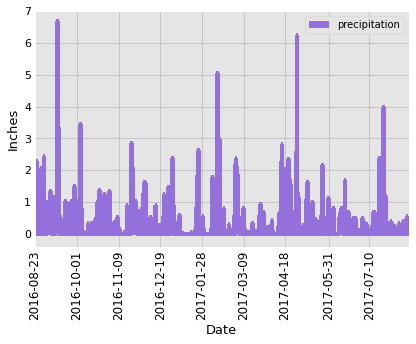

In [266]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
raw_measurement_date = []
final_measurement_dates = []
final_measurement_prcp = []


measurement_list = session.query(Measurement).filter(Measurement.prcp != " ").\
                                              filter(Measurement.date >= '2016-08-23')

# Calculate the date 1 year ago from the last data point in the database
months = ["Indice 0", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

for raw_measurement in measurement_list:
    raw_measurement_date.append(raw_measurement.date)

final_measurement_date = raw_measurement_date[-1].split("-")
raw_one_year_ago_date = str(dt.date(int(final_measurement_date[0]), int(final_measurement_date[1]), int(final_measurement_date[2])) - dt.timedelta(days=365))
final_one_year_ago_date = raw_one_year_ago_date.split("-")
print(f"The date 1 year ago from the last data point in the database is {months[int(final_one_year_ago_date[1])]} {final_one_year_ago_date[2]}rd, {final_one_year_ago_date[0]}.")

# Perform a query to retrieve the data and precipitation scores
for final_measurement in measurement_list:
    final_measurement_dates.append(final_measurement.date)
    final_measurement_prcp.append(final_measurement.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
df_raw_measurement = pd.DataFrame({"Date": final_measurement_dates,
                                   "Precipitation": final_measurement_prcp})

df_intermediary_measurement = df_raw_measurement.set_index("Date")

# Sort the dataframe by date
df_measurement = df_intermediary_measurement.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
bar_chart = os.path.join("..", "sqlalchemy-challenge", "bar chart.png")
df_measure = df_measurement.reset_index()
final_df_measure = df_measure.rename(columns={"Precipitation":"precipitation"})

y_axis_ticks = np.arange(0, 8, 1)
tickers = ["2016-08-23", "2016-10-01", "2016-11-09", "2016-12-19", "2017-01-28",
           "2017-03-09", "2017-04-18", "2017-05-31", "2017-07-10"]
x_axis_ticks = [list(df_measure["Date"]).index(tickers_location) for tickers_location in tickers]

with plt.style.context('ggplot'):
    final_df_measure.plot.bar(color="mediumpurple", figsize=(6, 5), align="center", ylim=(-0.4, 7), width=25, xerr=7, ecolor="mediumpurple")
plt.xlabel("Date", color="black", fontsize=13)
plt.ylabel("Inches", color="black", fontsize=13)
plt.yticks(y_axis_ticks, color="black", fontsize=11)
plt.xticks(x_axis_ticks, tickers, rotation="vertical", color="black", fontsize=12)
plt.xlim(0, 2021)
plt.grid(color="grey", alpha=0.3, linewidth=1)
plt.tight_layout()
plt.savefig(bar_chart)
plt.show()

In [267]:
# Use Pandas to calcualte the summary statistics for the precipitation data
final_df_measure[["precipitation"]].describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [268]:
# Design a query to show how many stations are available in this dataset?
measurement_station_values_list = []

station_count = session.query(Station.station).count()
measurument_station_values = session.query(Measurement.station)
for measurument_station_value in measurument_station_values:
    measurement_station_values_list.append(measurument_station_value.station)
alternative_station_count = len(Counter(measurement_station_values_list).keys())
print(f"The number of stations available in this dataset is of {station_count or alternative_station_count}.")

The number of stations available in this dataset is of 9.


In [269]:
# What are the most active stations? (i.e. what stations have the most rows)?
columns = ["Station", "Station Count"]
station_query = [Measurement.station, func.count(Measurement.station)]          
raw_station_df = session.query(*station_query).\
                 group_by(Measurement.station).\
                 order_by(func.count(Measurement.station).desc()).all()

three_most_active_stations = session.query(*station_query).\
                             group_by(Measurement.station).\
                             order_by(func.count(Measurement.station).desc()).limit(3).all()

most_active_station = session.query(*station_query).\
                      group_by(Measurement.station).\
                      order_by(func.count(Measurement.station).desc()).limit(1).all()

print(f"The three most active stations are the {three_most_active_stations[0][0]}, the {three_most_active_stations[1][0]} and the {three_most_active_stations[2][0]} stations.")
print(f"The most active station is the {most_active_station[0][0]} station.")

# List the stations and the counts in descending order.
station_df = pd.DataFrame(raw_station_df, columns=["Station", "Station Count"])
station_df

The three most active stations are the USC00519281, the USC00519397 and the USC00513117 stations.
The most active station is the USC00519281 station.


,Station,Station Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [270]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temperature_query = [Measurement.station, func.min(Measurement.tobs)]    
highest_temperature_query = [Measurement.station, func.max(Measurement.tobs)]   
average_temperature_query = [Measurement.station, func.avg(Measurement.tobs)] 

lowest_temperature = session.query(*lowest_temperature_query).filter(Measurement.station == raw_station_df[0][0])
highest_temperature = session.query(*highest_temperature_query).filter(Measurement.station == raw_station_df[0][0])
average_temperature = session.query(*average_temperature_query).filter(Measurement.station == raw_station_df[0][0])

final_lowest_temperature = lowest_temperature.all()
final_highest_temperature = highest_temperature.all()
final_average_temperature = average_temperature.all()

print(f"the lowest temperature recorded for the {raw_station_df[0][0]} station is of {('{:.0f}').format(final_lowest_temperature[0][1])} °F.")
print(f"the highest temperature recorded for the {raw_station_df[0][0]} station is of {('{:.0f}').format(final_highest_temperature[0][1])} °F.")
print(f"the average temperature recorded for the {raw_station_df[0][0]} station is of {round(final_average_temperature[0][1], 2)} °F.")

the lowest temperature recorded for the USC00519281 station is of 54 °F.
the highest temperature recorded for the USC00519281 station is of 85 °F.
the average temperature recorded for the USC00519281 station is of 71.66 °F.


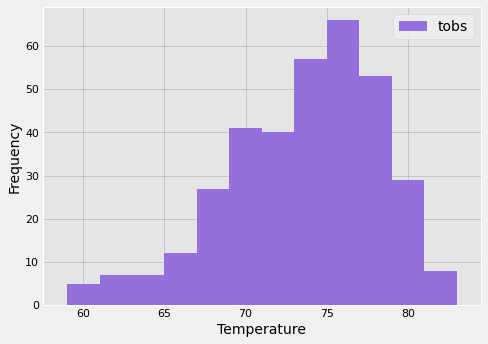

In [271]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram_list = []
highest_obeservation_number = session.query(Measurement).filter(Measurement.station == raw_station_df[0][0]).\
                                                         filter(Measurement.date >= '2016-08-23')
                                                         
for highest_number in highest_obeservation_number:
    histogram_list.append(highest_number.tobs)

frequency = np.arange(0, 80, 10)
temperature = np.arange(60, 85, 5)

plt.figure(figsize=(7, 5))
with plt.style.context('ggplot'):
    plt.hist(histogram_list, bins=12, color="mediumpurple", label="tobs")
plt.xlabel("Temperature", fontsize=14, color="black")
plt.ylabel("Frequency", fontsize=14, color="black")
plt.yticks(frequency, rotation=0, color="black", fontsize=11)
plt.xticks(temperature, rotation=0, color="black", fontsize=11)
plt.legend(loc="upper right")

plt.xlim(min(histogram_list)-1.5, max(histogram_list)+1.5)
plt.ylim(0, 69)
plt.grid(color="grey", alpha=0.3, linewidth=1)

histogram = os.path.join("..", "sqlalchemy-challenge", "histogram.png")
plt.tight_layout()
plt.savefig(histogram)
plt.show()

## Bonus Challenge Assignment

In [272]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [273]:
# Temperature Analysis 1
june_december_temperatures_query = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "6").\
                                                                                     filter(func.strftime("%m", Measurement.date) == "12").all()
june_december_temperatures_query

[]

In [274]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [275]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [276]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [277]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [278]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [279]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [280]:
# Plot the daily normals as an area plot with `stacked=False`
